In [1]:
import os
import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import Input, Model
from tensorflow.keras import losses, optimizers
from tensorflow.keras import callbacks
import tensorflow.keras.backend as K
import tensorflow as tf

In [2]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download 'mateuszbuda/lgg-mri-segmentation'

100% 712M/714M [00:33<00:00, 25.1MB/s]
100% 714M/714M [00:33<00:00, 22.6MB/s]


In [5]:
!unzip -qq lgg-mri-segmentation.zip

In [6]:
dirs = os.listdir('./lgg-mri-segmentation/kaggle_3m')
all_data = []
all_masks = []


for d in dirs:
  dd = os.path.join('./lgg-mri-segmentation/kaggle_3m', d)
  if not (os.path.isdir(dd)):
    continue    
  all_paths = glob.glob(os.path.join(dd, '*.tif'))
  masks_paths = glob.glob(os.path.join(dd, '*mask.tif'))
  image_paths = list(set(all_paths) - set(masks_paths))

  masks_paths.sort(key=lambda x : int(x.split('_')[-2]))
  image_paths.sort(key=lambda x : int(x.split('_')[-1][:-4]))

  all_data.extend(image_paths)
  all_masks.extend(masks_paths)

In [7]:
images = []
masks = []

for f_img, f_msk in tqdm(zip(all_data, all_masks)):
    _msk = cv2.imread(f_msk, cv2.IMREAD_GRAYSCALE)
    _msk = cv2.resize(_msk, (128, 128))
    _msk[_msk>0.05] = 1.0
    # _msk = _msk > 0.05

    if np.sum(_msk) > 100:
        masks.append(_msk)
        _img = cv2.imread(f_img)
        _img = cv2.resize(_img, (128, 128))
        _img = (np.array(_img) - np.min(_img)) / (np.max(_img) - np.min(_img))
        images.append(_img)


images = np.array(images, dtype='float32')
masks = np.array(masks, dtype='float32')
masks = np.expand_dims(masks, axis=-1)

3929it [00:02, 1699.41it/s]


(-0.5, 127.5, 127.5, -0.5)

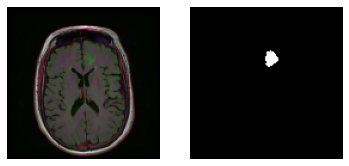

In [8]:
plt.subplot(121)
plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.squeeze(masks[0]), cmap='gray')
plt.axis('off')

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.2)

print('Train Data', X_train.shape)
print('Train Masks', Y_train.shape)

print('Test Data', X_test.shape)
print('Test Masks', Y_test.shape)

Train Data (978, 128, 128, 3)
Train Masks (978, 128, 128, 1)
Test Data (245, 128, 128, 3)
Test Masks (245, 128, 128, 1)


## Model Design

In [ ]:
def conv_block(num_filters, inp):
  c1 = layers.Conv2D(num_filters, 3, padding='same')(inp)
  x = layers.BatchNormalization()(c1)
  x = layers.Activation('relu')
  x = layers.Conv2D(num_filters, 3, activation='relu', padding='same', strides=2)(c1)
  return x, c1

def up_conv_block(num_filters, inp1, inp2):
  x = layers.Conv2DTranspose(num_filters, 3, 2, padding='same')(inp1)
  x = layers.Concatenate()([inp2, x])
  x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
  return x


# Functional API
inp = Input(shape = (128, 128, 3))
x, c1 = conv_block(4, inp)
x, c2 = conv_block(8, x)
x, c3 = conv_block(16, x)
x, c4 = conv_block(32, x)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

x = up_conv_block(32, x, c4)
x = up_conv_block(16, x, c3)
x = up_conv_block(8, x, c2)
x = up_conv_block(4, x, c1)

out = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

model = Model(inputs=inp, outputs=out)
model.summary()


## Training

In [25]:
def tversky(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss

In [12]:
## Callbacks
checkpoint_1 = callbacks.ModelCheckpoint('model.h5', save_best_only=True)
logger = callbacks.CSVLogger('log.csv')
es = callbacks.EarlyStopping(patience=5)

callbacks = [checkpoint_1, logger, es]

In [ ]:
model.compile(loss=bce_dice_loss, optimizer=optimizers.Adam(), metrics=[dice_coef])
history = model.fit(X_train, Y_train,
                    epochs = 50,
                    batch_size = 32,
                    callbacks = callbacks,
                    validation_data = (X_test, Y_test))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [32]:
model.evaluate(X_test, Y_test)
preds = model.predict(X_test)

8/8 [==============================] - 0s 12ms/step


In [16]:
preds_final = preds > 0.3

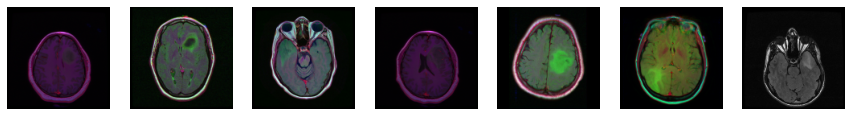

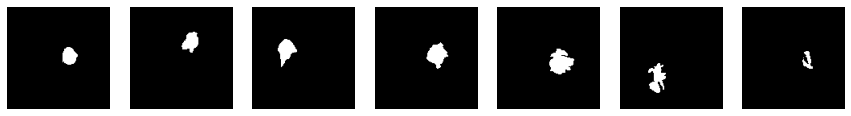

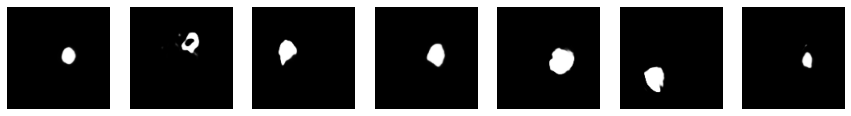

In [33]:
num_images = 7
fig, axes = plt.subplots(1, num_images, figsize=(15,20))
for i in range(num_images):
  axes[i].imshow(X_test[i])
  axes[i].set_axis_off()

fig, axes = plt.subplots(1, num_images, figsize=(15,20))
for i in range(num_images):
  axes[i].imshow(np.squeeze(Y_test[i]), cmap='gray')
  axes[i].set_axis_off()

fig, axes = plt.subplots(1, num_images, figsize=(15,20))
for i in range(num_images):
  axes[i].imshow(np.squeeze(preds[i]), cmap='gray')
  axes[i].set_axis_off()